# ASTR 596: The Midterm

#### 5 parts, 20 pts each. Some parts are easier than others, so are essentially free points, but you'll need to solve the earlier parts correctly to get the right answer on the later parts. I'd strongly recommend skimming the Riess et al. 2011 paper. 

#### We've been building up our ability to deal with complex data, and you've now got the ability to fit straight lines with frequentist tools (as you did with the Cepheids), and infer constraints on more complex high-dimensional models given the data with MCMC. So let's combine the two and infer one of the most important numbers in the Universe - the Hubble constant.

#### There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

#### Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file `R11ceph.dat`.

In [1]:
exec(open('cepheids.py').read())
ceph = Cepheids('R11ceph.dat')
hosts = ceph.list_hosts()

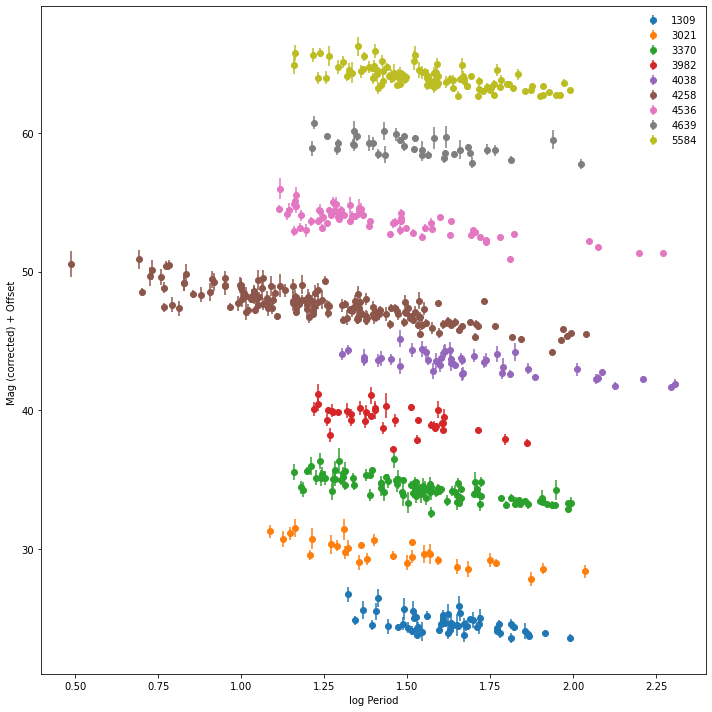

In [2]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Here I load the data -- I modified the .dat file for easier use, but have saved 
# the other one too to keep possibly critical information in case I need it. 

df = pd.read_table('R11ceph_DV.dat', sep='\s+')
df.columns

# Now separate by galaxy ID -- will be important for modeling, albeit tedious 

d1309 = df[df['gal'] == 1309]
d3021 = df[df['gal'] == 3021]
d3370 = df[df['gal'] == 3370]
d3982 = df[df['gal'] == 3982]
d4038 = df[df['gal'] == 4038]
d4258 = df[df['gal'] == 4258]
d4536 = df[df['gal'] == 4536]
d4639 = df[df['gal'] == 4639]
d5584 = df[df['gal'] == 5584]

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


In [4]:
# here we create our data and model functions. Data is just magnitudes,
# and we are of course trying to model the magnitudes using the period
# and a simple linear model i.e. y = mx+b. We also include some error
# on the measurements

def data(df):
    
    return df.m

def model(df, slope, intercept):
    
    return intercept + (slope * np.log10(df.P))

def error(df):
    
    return df.merr

# likelihood function

def chiSq(data, model, error):
    
    chi = np.sum(((data - model) / error)**2)
    
    return chi

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

In [5]:
# I messed up the last homework pretty badly, though I gave it
# a good shot. Who doesn't love a redemption story, though? 

import emcee
import sys
import os
import shutil

import time
start = time.time()

# Here I define my priors and probability functions within this one 
# function, which I will later call in my MCMC function.

def lnprob(p0):
    
    # p0 -- what parameters am I modeling? 
    
    m, zp, intercept_1309, intercept_3021, intercept_3370, intercept_3982, intercept_4038, intercept_4536, intercept_4639, intercept_5584 = p0
    
    # I utilize three sets of priors here -- one for the slope, one for the intercept, and one for the zp_w term
    
    priors_slope = [-5, -1] # my rationale here is that one can eyeball the slopes in Figure 7 and see
                            # that they aren't so steep. Given the rise vs. run, I expect the slope
                            # to be somewhere between 2 to 3 ish. So this is why I use these priors.
            
    priors_zp = [20, 30]    # If we look at Equation 1 and ignore the metallicity term, we know
                            # that the left hand side will be something like 23-28ish from the 
                            # values in our table. We know the slope * log P will be something like
                            # 4 - 5 in total, given our priors and knowledge of the log P values.
                            # We also can eyeball that the intercepts are not so stark. Therefore,
                            # to make everything work out, zp_w will necessarily need to be in the
                            # range of 20-30, in a similar range as the magnitude range. 
                            
    priors_intercept = [0, 10]      # we know from Table 3 that this number should be pretty small...
    
                                    # though, being perfectly honest, I ended up eyeballing this one,
                                    # using a shorter range after many failed MCMC runs. This was just
                                    # the result of trial and error, and managed to land somewhere 
                                    # thanks to your assistance in office hours, since my original 
                                    # priors were waaaaaaaaaaaaayyy too broad... thanks! 
                    
# Wonderful. Now we implement our priors such that our MCMC function
# will return a -np.inf if our walkers end up outside of the prior 
# range, which will cause our walkers to avoid these regions of 
# parameter space while attemping to maximize the log likelihood 
    
    if m < priors_slope[0] or m > priors_slope[1]:
        return -np.inf
    
    if zp < priors_zp[0] or zp > priors_zp[1]:
        return -np.inf
    
    if intercept_1309 < priors_intercept[0] or intercept_1309 > priors_intercept[1]:
        return -np.inf
    
    if intercept_3021 < priors_intercept[0] or intercept_3021 > priors_intercept[1]:
        return -np.inf
    
    if intercept_3370 < priors_intercept[0] or intercept_3370 > priors_intercept[1]:
        return -np.inf
    
    if intercept_3982 < priors_intercept[0] or intercept_3982 > priors_intercept[1]:
        return -np.inf
    
    if intercept_4038 < priors_intercept[0] or intercept_4038 > priors_intercept[1]:
        return -np.inf
    
    if intercept_4536 < priors_intercept[0] or intercept_4536 > priors_intercept[1]:
        return -np.inf
    
    if intercept_4639 < priors_intercept[0] or intercept_4639 > priors_intercept[1]:
        return -np.inf
    
    if intercept_5584 < priors_intercept[0] or intercept_5584 > priors_intercept[1]:
        return -np.inf
    
# Lastly we calculate the chi-squared for each galaxy, basically implementing
# the likelihood function into our eventual MCMC run.
    
    C1 = chiSq(data(d1309), model(df=d1309, slope=m, intercept=intercept_1309+zp), error(d1309))
    C2 = chiSq(data(d3021), model(df=d3021, slope=m, intercept=intercept_3021+zp), error(d3021))
    C3 = chiSq(data(d3370), model(df=d3370, slope=m, intercept=intercept_3370+zp), error(d3370))
    C4 = chiSq(data(d3982), model(df=d3982, slope=m, intercept=intercept_3982+zp), error(d3982))
    C5 = chiSq(data(d4038), model(df=d4038, slope=m, intercept=intercept_4038+zp), error(d4038))
    C6 = chiSq(data(d4536), model(df=d4536, slope=m, intercept=intercept_4536+zp), error(d4536))
    C7 = chiSq(data(d4639), model(df=d4639, slope=m, intercept=intercept_4639+zp), error(d4639))
    C8 = chiSq(data(d5584), model(df=d5584, slope=m, intercept=intercept_5584+zp), error(d5584))
    
# Important to note that I use NGC 4258 as my zero point here, which means that the 
# only term contributing to the intercept is zp_w. 

    C9 = chiSq(data(d4258), model(df=d4258, slope=m, intercept=zp), error(d4258)) 
    
# And now, since ln(probs) = -1/2 * chi^2, we have our function!
    
    return (C1 + C2 + C3 + C4 + C5 + C6 + C7 + C8 + C9) * -0.5

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [6]:
# As I wrote in my previous homework, this MCMC code is a streamlined
# version of my undergraduate MCMC code that I co-wrote with another
# person in my research group for my thesis. This class has already
# shown me that this code is remarkably slow. Nevertheless, I know 
# how this one works, and decided to stick with it. 

# First we define our MCMC function...

def MCMC(nsteps=1000, ndim=10, nwalkers=20, param_1 = -3, param_2 = 25, param_3 = 2, param_4 = 2, 
         param_5 = 2, param_6 = 2, param_7 = 2, param_8 = 2, param_9 = 2, param_10 = 2,
         sigma_1 = 1.5, sigma_2 = 1.5, sigma_3 = 1.5, sigma_4 = 1.5, sigma_5 = 1.5, sigma_6 = 1.5, 
         sigma_7 = 1.5, sigma_8 = 1.5, sigma_9 = 1.5, sigma_10 = 1.5):
    
# We give the initial place for our walkers to start + the max length
# of the stretch move which will be sampled from a 10-dimensional 
# normal distribution (as we have 10 parameters to model).

    p0 = np.random.normal(loc=(param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8, param_9, param_10), size=(nwalkers, ndim), 
                          scale=(sigma_1, sigma_2, sigma_3, sigma_4, sigma_5, sigma_6, sigma_7, sigma_8, sigma_9, sigma_10))
    
# Now we initialize the sampler with our number of walkers, number
# of dimensions, and our probability function. 
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
    run = sampler.sample(p0, iterations=nsteps, store=True)
    
# Lastly we need to store our chains somewhere -- this part of the 
# is where we do that... 

    steps = []
    
    for i, result in enumerate(run):
        pos, lnprobs, blob = result
        
        new_step = [np.append(pos[k], lnprobs[k]) for k in range(nwalkers)]
        steps += new_step
        df = pd.DataFrame(steps)
        df.columns = ['slope', 'zp', 'i_1309', 'i_3021', 'i_3370', 'i_3982', 'i_4038', 'i_4536', 'i_4639', 'i_5584', 'lnprobs']
        df.to_csv('503_midterm_final_run.csv', mode='w')
        sys.stdout.write('completed step {} out of {} \r'.format(i, nsteps) )
        sys.stdout.flush()
        
# Also some helpful information for me after a run, once 
# the code is finished
        
    print('Finished MCMC')
    print('Mean acceptance fraction: {0:3f}'.format(np.mean(sampler.acceptance_fraction)))
    print('Elapsed time (mins):' , (time.time() - start)/60)

In [7]:
# This is where we run our MCMC code!

MCMC(nsteps=4000)

/usr/local/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Finished MCMCp 3999 out of 4000 
Mean acceptance fraction: 0.418175
Elapsed time (mins): 65.291716782252


In [7]:
# Before I make the corner plot, I create this function which
# will allow me to look at any individual parameter and how
# the walkers navigate the space. It's incredibly useful for
# diagnosing problems with the runs.

nwalkers = 20

# With 4000 steps, I think 1000 steps of burn-in is a reasonable
# guess. I could also use the autocorrelation stuff or guess 
# with my eyes, but I don't think it matters too much. 

burnin = 1000
csvfile = '503_midterm_final_run.csv'
skiprows = nwalkers * burnin

walkers = pd.read_csv(csvfile)
walkers = walkers.drop(walkers.index[0:skiprows])

def walker_plot(arr, nwalkers=20):

        steps = len(arr) / nwalkers

        plt.figure(figsize=(12,4))

        for n in range(nwalkers):
            w_n = arr[n::nwalkers]
            plt.plot(range(int(steps)), w_n)

        plt.xlabel('steps')
        plt.ylabel(str(arr.name))
        plt.show()

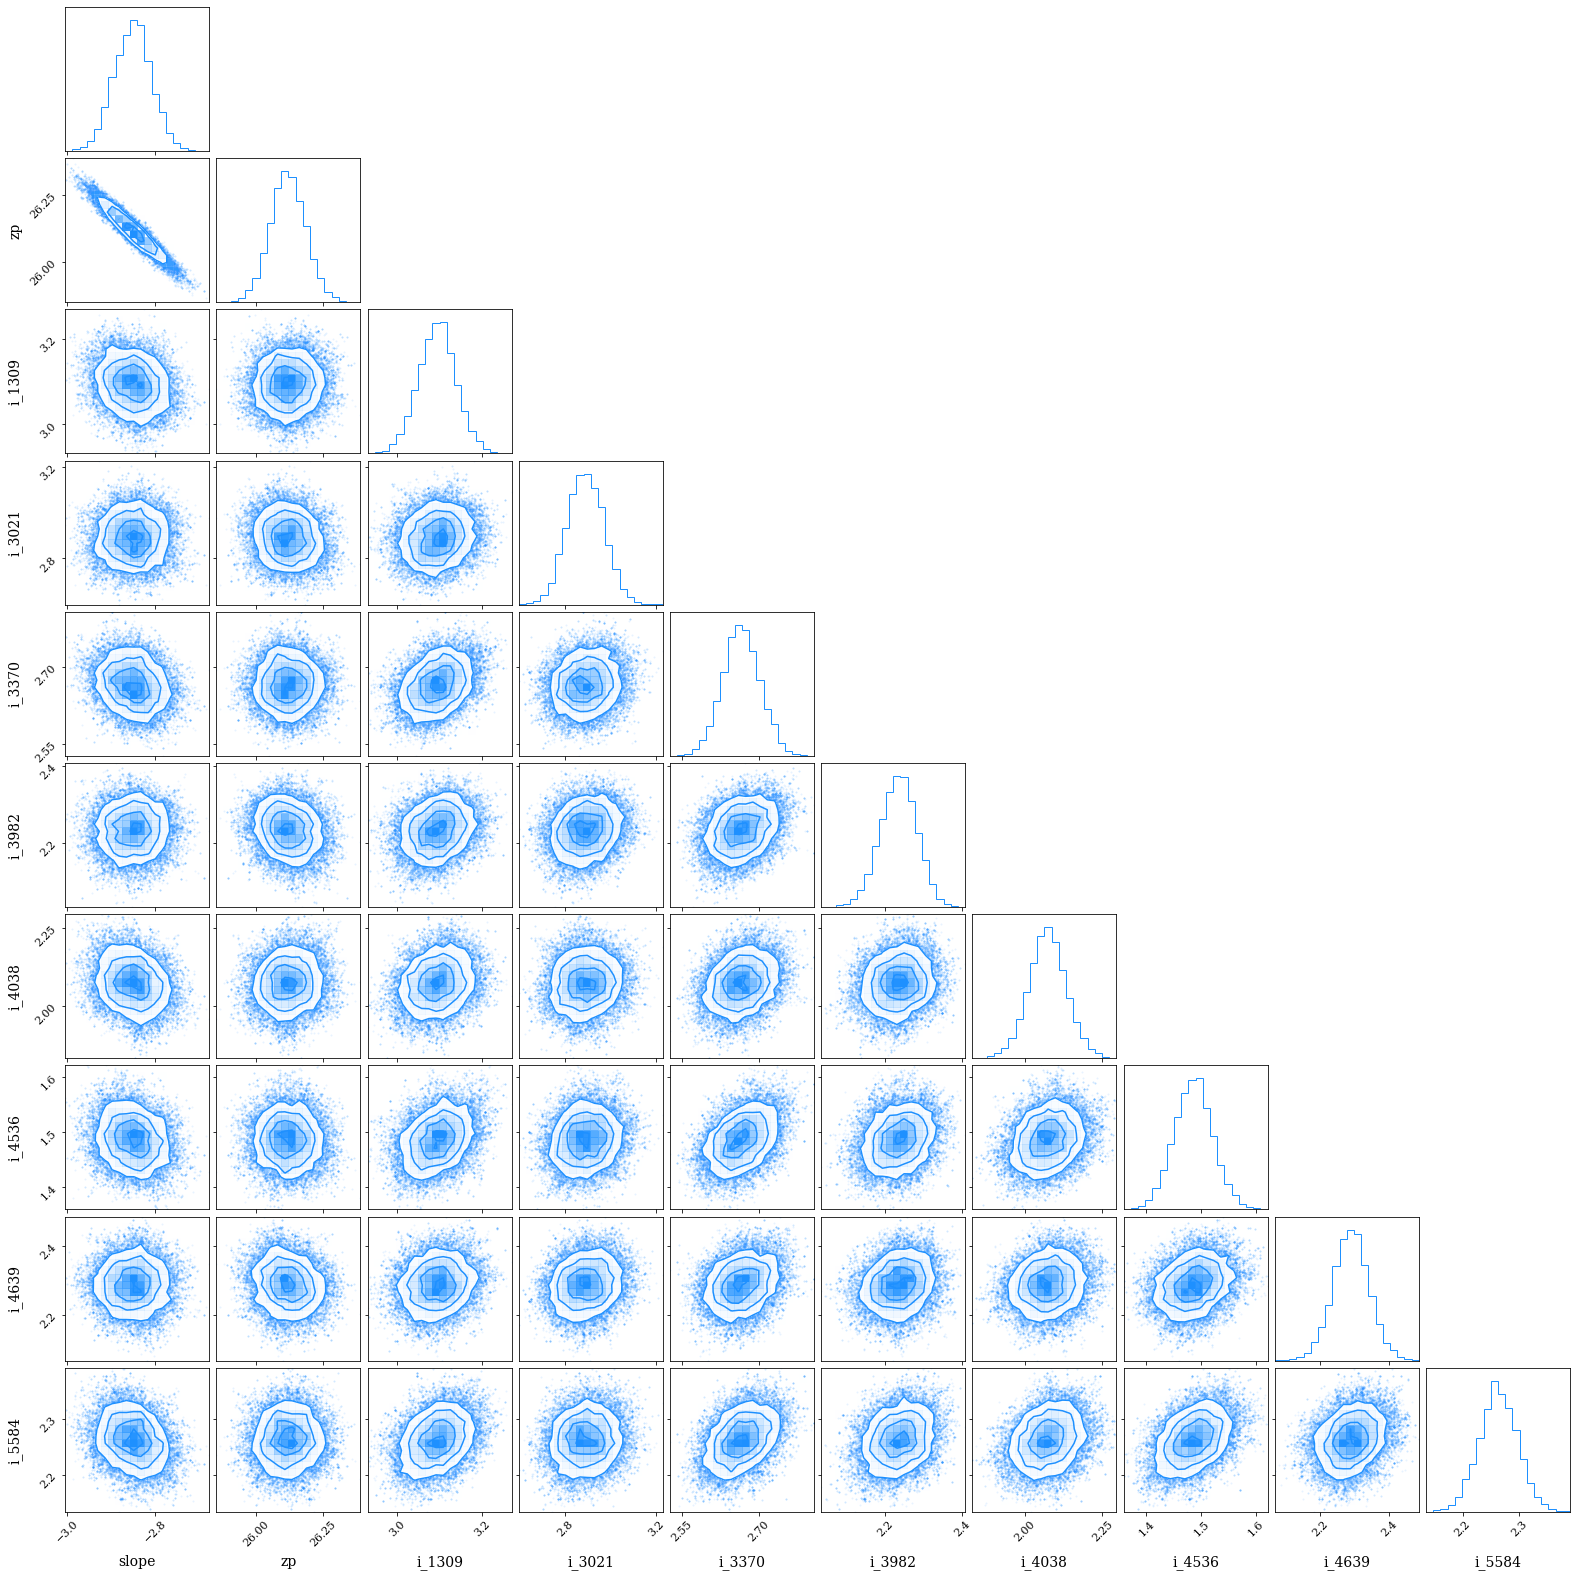

In [8]:
# Now for the corner plot!

import corner
import matplotlib as mpl

params = {'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'font.family': 'serif',
          'axes.labelsize': 14
          }

mpl.rcParams.update(params)

# Create corner plot function

def corner_plot(csvfile, skiprows):

    df = pd.read_csv(csvfile)
    df = df.drop(axis=1, labels='Unnamed: 0')
    df = df.drop(axis=1, labels='lnprobs')
    df = df.drop(df.index[0:skiprows])

    fig = corner.corner(df, color='dodgerblue', max_n_ticks=2)

# Look how beautiful this corner plot is! And also note the degeneracy
# between slope and zp_w... 
    
corner_plot(csvfile, skiprows)

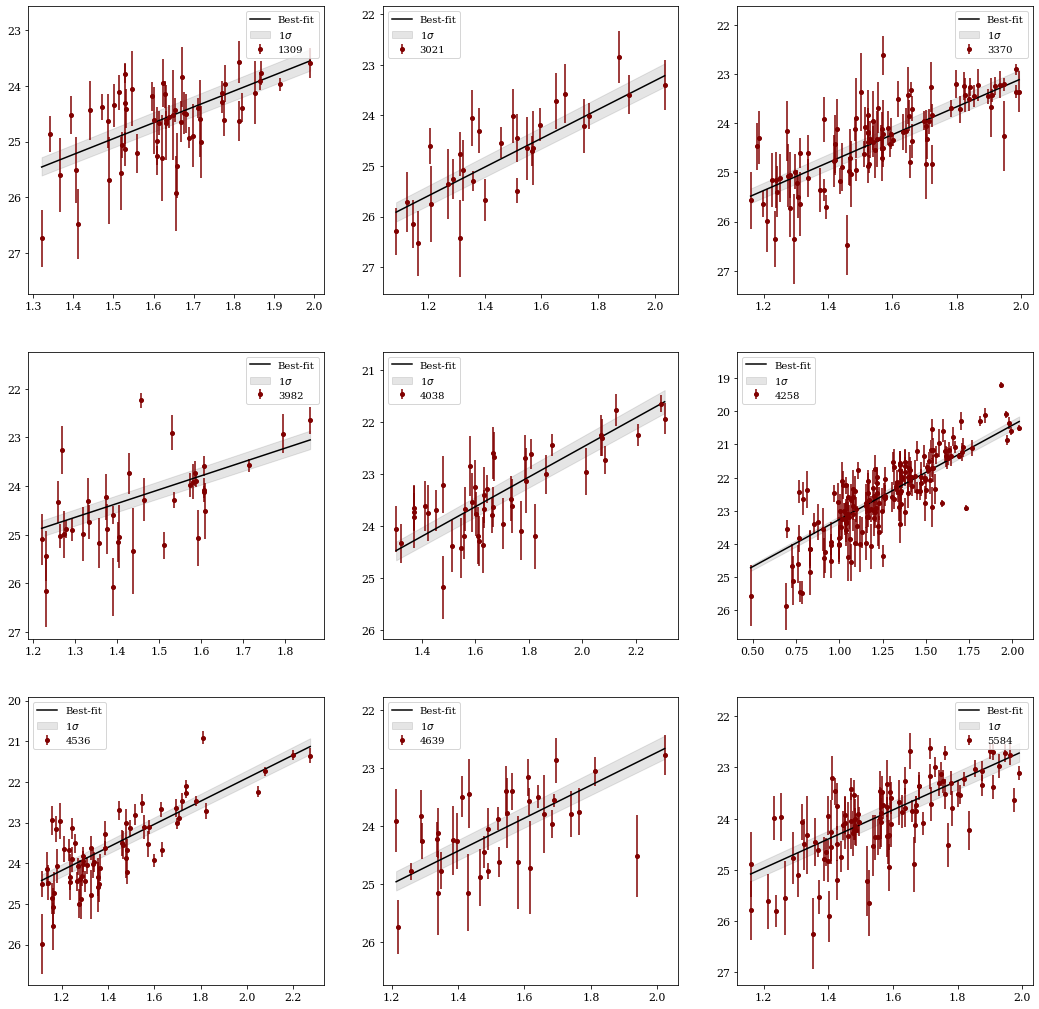

In [9]:
# Now I create my version of Figure 7 from Riess et al. (2011).
# I will note that I did not do random sampling for the errors,
# but rather ended up plotting the best-fit lines and the 
# 1-sigma lines of best best (i.e. 16th and 84th percentiles)

# This best-fit index allows me to find the best-fit 
# parameter from the line in the .csv file with the 
# highest lnprobs value

bf = walkers.lnprobs.idxmax()

# Here I create the x-dimension for plotting

def x_extent(df):
    
    return np.linspace(np.min(df.P), np.max(df.P), 10)

fig, axs = plt.subplots(3,3, figsize=[18,18])

# And now we plot! This should have been written in a nicer
# fashion (maybe with functions etc.) but it is what it is. 

axs[0,0].errorbar(np.log10(d1309.P), d1309.m, color='maroon', yerr=d1309.merr, linestyle='none', marker='o', label = '1309', markersize=4)
axs[0,0].plot(np.log10(x_extent(d1309)), walkers.i_1309[bf] + walkers.zp[bf] 
              + walkers.slope[bf] * np.log10(x_extent(d1309)), color='black', label='Best-fit')
axs[0,0].fill_between(np.log10(x_extent(d1309)), 
                      np.percentile(walkers.i_1309, 16) + np.percentile(walkers.zp, 16) + np.percentile(walkers.slope, 16) * np.log10(x_extent(d1309)),
                      np.percentile(walkers.i_1309, 84) + np.percentile(walkers.zp, 84) + np.percentile(walkers.slope, 84) * np.log10(x_extent(d1309)),
                      color='black', alpha=0.1, label=r'1$\sigma$')
axs[0,0].set_ylim(np.max(d1309.m) + 1, np.min(d1309.m) - 1)
axs[0,0].legend()


axs[0,1].errorbar(np.log10(d3021.P), d3021.m, color='maroon', yerr=d3021.merr, linestyle='none', marker='o', label = '3021', markersize=4)
axs[0,1].plot(np.log10(x_extent(d3021)), walkers.i_3021[bf] + walkers.zp[bf]
              + walkers.slope[bf] * np.log10(x_extent(d3021)), color='black', label='Best-fit')
axs[0,1].fill_between(np.log10(x_extent(d3021)), 
                      np.percentile(walkers.i_3021, 16) + np.percentile(walkers.zp, 16) + np.percentile(walkers.slope, 16) * np.log10(x_extent(d3021)),
                      np.percentile(walkers.i_3021, 84) + np.percentile(walkers.zp, 84) + np.percentile(walkers.slope, 84) * np.log10(x_extent(d3021)),
                      color='black', alpha=0.1, label=r'1$\sigma$')
axs[0,1].set_ylim(np.max(d3021.m) + 1, np.min(d3021.m) - 1)
axs[0,1].legend()


axs[0,2].errorbar(np.log10(d3370.P), d3370.m, color='maroon', yerr=d3370.merr, linestyle='none', marker='o', label = '3370', markersize=4)
axs[0,2].plot(np.log10(x_extent(d3370)), walkers.i_3370[bf] + walkers.zp[bf] 
              + walkers.slope[bf] * np.log10(x_extent(d3370)), color='black', label='Best-fit')
axs[0,2].fill_between(np.log10(x_extent(d3370)), 
                      np.percentile(walkers.i_3370, 16) + np.percentile(walkers.zp, 16) + np.percentile(walkers.slope, 16) * np.log10(x_extent(d3370)),
                      np.percentile(walkers.i_3370, 84) + np.percentile(walkers.zp, 84) + np.percentile(walkers.slope, 84) * np.log10(x_extent(d3370)),
                      color='black', alpha=0.1, label=r'1$\sigma$')
axs[0,2].set_ylim(np.max(d3370.m) + 1, np.min(d3370.m) - 1)
axs[0,2].legend()


axs[1,0].errorbar(np.log10(d3982.P), d3982.m, color='maroon', yerr=d3982.merr, linestyle='none', marker='o', label = '3982', markersize=4)
axs[1,0].plot(np.log10(x_extent(d3982)), walkers.i_3982[bf] + walkers.zp[bf] 
              + walkers.slope[bf] * np.log10(x_extent(d3982)), color='black', label='Best-fit')
axs[1,0].fill_between(np.log10(x_extent(d3982)), 
                      np.percentile(walkers.i_3982, 16) + np.percentile(walkers.zp, 16) + np.percentile(walkers.slope, 16) * np.log10(x_extent(d3982)),
                      np.percentile(walkers.i_3982, 84) + np.percentile(walkers.zp, 84) + np.percentile(walkers.slope, 84) * np.log10(x_extent(d3982)),
                      color='black', alpha=0.1, label=r'1$\sigma$')
axs[1,0].set_ylim(np.max(d3982.m) + 1, np.min(d3982.m) - 1)
axs[1,0].legend()


axs[1,1].errorbar(np.log10(d4038.P), d4038.m, color='maroon', yerr=d4038.merr, linestyle='none', marker='o', label = '4038', markersize=4)
axs[1,1].plot(np.log10(x_extent(d4038)), walkers.i_4038[bf] + walkers.zp[bf] 
              + walkers.slope[bf] * np.log10(x_extent(d4038)), color='black', label='Best-fit')
axs[1,1].fill_between(np.log10(x_extent(d4038)), 
                      np.percentile(walkers.i_4038, 16) + np.percentile(walkers.zp, 16) + np.percentile(walkers.slope, 16) * np.log10(x_extent(d4038)),
                      np.percentile(walkers.i_4038, 84) + np.percentile(walkers.zp, 84) + np.percentile(walkers.slope, 84) * np.log10(x_extent(d4038)),
                      color='black', alpha=0.1, label=r'1$\sigma$')
axs[1,1].set_ylim(np.max(d4038.m) + 1, np.min(d4038.m) - 1)
axs[1,1].legend()


axs[1,2].errorbar(np.log10(d4258.P), d4258.m, color='maroon', yerr=d4258.merr, linestyle='none', marker='o', label = '4258', markersize=4)
axs[1,2].plot(np.log10(x_extent(d4258)), walkers.zp[bf] 
              + walkers.slope[bf] * np.log10(x_extent(d4258)), color='black', label='Best-fit')
axs[1,2].fill_between(np.log10(x_extent(d4258)), 
                      np.percentile(walkers.zp, 16) + np.percentile(walkers.slope, 16) * np.log10(x_extent(d4258)),
                      np.percentile(walkers.zp, 84) + np.percentile(walkers.slope, 84) * np.log10(x_extent(d4258)),
                      color='black', alpha=0.1, label=r'1$\sigma$')
axs[1,2].set_ylim(np.max(d4258.m) + 1, np.min(d4258.m) - 1)
axs[1,2].legend()


axs[2,0].errorbar(np.log10(d4536.P), d4536.m, color='maroon', yerr=d4536.merr, linestyle='none', marker='o', label = '4536', markersize=4)
axs[2,0].plot(np.log10(x_extent(d4536)), walkers.i_4536[bf] + walkers.zp[bf] 
              + walkers.slope[bf] * np.log10(x_extent(d4536)), color='black', label='Best-fit')
axs[2,0].fill_between(np.log10(x_extent(d4536)), 
                      np.percentile(walkers.i_4536, 16) + np.percentile(walkers.zp, 16) + np.percentile(walkers.slope, 16) * np.log10(x_extent(d4536)),
                      np.percentile(walkers.i_4536, 84) + np.percentile(walkers.zp, 84) + np.percentile(walkers.slope, 84) * np.log10(x_extent(d4536)),
                      color='black', alpha=0.1, label=r'1$\sigma$')
axs[2,0].set_ylim(np.max(d4536.m) + 1, np.min(d4536.m) - 1)
axs[2,0].legend()


axs[2,1].errorbar(np.log10(d4639.P), d4639.m, color='maroon', yerr=d4639.merr, linestyle='none', marker='o', label = '4639', markersize=4)
axs[2,1].plot(np.log10(x_extent(d4639)), walkers.i_4639[bf] + walkers.zp[bf] 
              + walkers.slope[bf] * np.log10(x_extent(d4639)), color='black', label='Best-fit')
axs[2,1].fill_between(np.log10(x_extent(d4639)), 
                      np.percentile(walkers.i_4639, 16) + np.percentile(walkers.zp, 16) + np.percentile(walkers.slope, 16) * np.log10(x_extent(d4639)),
                      np.percentile(walkers.i_4639, 84) + np.percentile(walkers.zp, 84) + np.percentile(walkers.slope, 84) * np.log10(x_extent(d4639)),
                      color='black', alpha=0.1, label=r'1$\sigma$')
axs[2,1].set_ylim(np.max(d4639.m) + 1, np.min(d4639.m) - 1)
axs[2,1].legend()


axs[2,2].errorbar(np.log10(d5584.P), d5584.m, color='maroon', yerr=d5584.merr, linestyle='none', marker='o', label = '5584', markersize=4)
axs[2,2].plot(np.log10(x_extent(d5584)), walkers.i_5584[bf] + walkers.zp[bf] 
              + walkers.slope[bf] * np.log10(x_extent(d5584)), color='black', label='Best-fit')
axs[2,2].fill_between(np.log10(x_extent(d5584)), 
                      np.percentile(walkers.i_5584, 16) + np.percentile(walkers.zp, 16) + np.percentile(walkers.slope, 16) * np.log10(x_extent(d5584)),
                      np.percentile(walkers.i_5584, 84) + np.percentile(walkers.zp, 84) + np.percentile(walkers.slope, 84) * np.log10(x_extent(d5584)),
                      color='black', alpha=0.1, label=r'1$\sigma$')
axs[2,2].set_ylim(np.max(d5584.m) + 1, np.min(d5584.m) - 1)
axs[2,2].legend()

# The result: 

plt.show()

In [10]:
# Lastly, here we compare the calculated intercept values 
# to Table 3 from Riess et al. (2011). 

def percentiles(qq):
    
    return(str(np.median(qq)) + ', + ' + str(np.percentile(qq, 84) - np.percentile(qq, 50))
          + ', - ' + str(np.percentile(qq, 50) - np.percentile(qq, 16)))

# use this function to write the information below:

percentiles(walkers.i_5584)

'2.262921096662631, + 0.03405486199477403, - 0.033186892576557714'

For NGC 1309 we obtain a $\mu_0 - \mu$ value of 3.10 $\pm$ 0.04.
Riess et al. (2011) finds a value of 3.276.

For NGC 3021 we obtain a $\mu_0 - \mu$ value of 2.89 $\pm$ 0.08.
Riess et al. (2011) finds a value of 3.138.

For NGC 3370 we obtain a $\mu_0 - \mu$ value of 2.67 $^{+0.04}_{-0.03}$.
Riess et al. (2011) finds a value of 2.835.

For NGC 3982 we obtain a $\mu_0 - \mu$ value of 2.23 $\pm$ 0.05
Riess et al. (2011) finds a value of 2.475.

For NGC 4038 we obtain a $\mu_0 - \mu$ value of 2.07 $\pm$ 0.06
Riess et al. (2011) finds a value of 2.396.

We do not compare $\mu_0 - \mu$ for NGC 4258, as it served as our zero point.

For NGC 4536 we obtain a $\mu_0 - \mu$ value of 1.49 $^{+0.03}_{-0.04}$.
Riess et al. (2011) finds a value of 1.567.

For NGC 4639 we obtain a $\mu_0 - \mu$ value of 2.29 $\pm$ 0.05
Riess et al. (2011) finds a value of 2.383.

Lastly, for NGC 5584 we obtain a $\mu_0 - \mu$ value of 2.26 $\pm$ 0.03
Riess et al. (2011) finds a value of 2.461.

For most of the galaxies, Riess's values lie outside 3$\sigma$ of our calculations. Perhaps running the chains for more steps (e.g. 5000-10000) would allow our measurements to converge. 

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

From Equation 3 of Riess et al. (2011):

$$
m^{0}_{v,i} = (\mu_{0, i} - \mu_{0, 4258}) + m^{0}_{v,4258}
$$

Thus 

$$
m^{0}_{v,4258} = m^{0}_{v,i} - (\mu_{0, i} - \mu_{0, 4258})
$$

Substituting into Equation 4 from Riess et al. (2011) gives

$$ 
\log H_0 = \frac{m^{0}_{v,i} - (\mu_{0, i} - \mu_{0, 4258}) - \mu_{0, 4258} + 5a_v + 25}{5}
$$

Which can be reorganized as 

$$ 
\boxed{\log H_0 = 5 + \frac{m^{0}_{v,i} + 5a_v - (\mu_{0, i} - \mu_{0, 4258}) - \mu_{0, 4258}}{5}}
$$

Within the fraction, the $m^{0}_{v,i} + 5a_v$ term is listed in Riess+11 -- I've placed the proper values into the coded answer for Part 5 -- and the individual $\mu_{0, 4258}$ is found in Humphreys et al. (2013): $\sim$ 7.60 Mpc, which we convert to $\mu$ via the equation

$$
\mu = 5 \log (\frac{d = 7.60 \ \rm{Mpc}}{10 \ \rm{pc}}) \simeq \boxed{29.4}
$$

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

In [11]:
# Here we calculate our log Hubble constant posteriors from the 
# intercept posteriors, which were generated via MCMC

logH0_1309 = 5 + ((16.768 - (walkers.i_1309) - 29.4) / 5)
logH0_3021 = 5 + ((16.699 - (walkers.i_3021) - 29.4) / 5)
logH0_3370 = 5 + ((16.545 - (walkers.i_3370) - 29.4) / 5)
logH0_3982 = 5 + ((15.953 - (walkers.i_3982) - 29.4) / 5)
logH0_4038 = 5 + ((15.901 - (walkers.i_4038) - 29.4) / 5)
logH0_4536 = 5 + ((15.147 - (walkers.i_4536) - 29.4) / 5)
logH0_4639 = 5 + ((16.040 - (walkers.i_4639) - 29.4) / 5)
logH0_5584 = 5 + ((16.274 - (walkers.i_5584) - 29.4) / 5)

# Now we go from log H0 to H0 via simple math
# i.e. H0 = 10**log_10(H0)

H0_1309 = 10**logH0_1309
H0_3021 = 10**logH0_3021
H0_3370 = 10**logH0_3370
H0_3982 = 10**logH0_3982
H0_4038 = 10**logH0_4038
H0_4536 = 10**logH0_4536
H0_4639 = 10**logH0_4639
H0_5584 = 10**logH0_5584

# Now I create an array of all my H0 posteriors from each galaxy:

H0_ps = [H0_1309, H0_3021, H0_3370, H0_3982, H0_4038, H0_4536, H0_4639, H0_5584]

# And now, remember that function I used in Part 3 to get the 1-sigma
# uncertainties? I use it again for the final answer! Voila...

percentiles(H0_ps)

'74.87252421208427, + 5.2400605659904045, - 3.477472011282245'

Therefore we determine a Hubble constant $H_0$ of 

$$
\boxed{H_0 = 74.9^{+5.2}_{-3.5} \ \rm{km \ s^{-1} \ Mpc^{-1}}}
$$

Whereas Riess et al. (2011) finds 

$$ 
H_0 = 74.8 \pm 3.0 \ \rm{km \ s^{-1} \ Mpc^{-1}}
$$

I think that with more steps and with some tweaked priors, we would get even closer, but I'm really happy with this result!